# Parkzap Labs Machine Learning Associate Task - Anand

 Task : Object Classification model to identify the model of a car from an image.
 
 <b>Completed tasks 1 and 2 and created dataset (2000 Images) and trained car classifer that achieves 85% accuracy when classifying between Swift/Innova.</b><br>
 
# Binary Car classifier that classifies images of Maruti/Suzuki Swift and Toyota Innova.

 #### A. Findings presented in this readme using model created in PyTorch (conversion of <i>convnet_img_dim_test.ipynb notebook</i>)
 #### B. For just inferencing test using best model - Section 5 of Notebook.
 
## Files of Interest :
1. Unprocessed images - CarImages folder.
2. Best Model - convnet_img_dim_test.ipynb
3. Preprocessed Dataset - Car_classifier_data_120_val.npy
4. Saved model/Checkpoint - checkpoint_acc_0.867_img_size120_batch_50_epochs_20.pt
5. Validation metrics on older model - convnet-Validation_metrics.ipynb
6. Validation using your files - Validate folder and section 5.

# 0. Gathering the data
 
1. Used <b> google_images_download </b> python web scraping module that uses a Selenium and BeautifulSoup backend to get images from google.
2. Download around 1500 images for each class - Swift, Innova.
3. Manually removed irrelevant examples.
4. Final division stood around a <b>1000</b> images for each(Balanced Dataset.)

# 1 Preparing Dataset 
1. Created Dataset and saved in the form of numpy array <b> "Car_classifier_data_120.npy" </b>.
2. <b>Resized images to 120*120 due to GPU VRAM Restrictions.</b>

## 1.1 Loading Images and creating dataset with labels.

1. <b> Suffled data </b> when creating dataset.
2. Classification Ouputs Label in the form of Tensor index.<br>
Tensor [Swift, Innova]


In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm    # for progress meter in loop


REBUILD_DATA = False   # Set to false if you don't want to rebuild train, test sets for each execution. 
IMG_SIZE = 120

class SwiftVsInnova():
    IMG_SIZE = 120
    Swift = "CarImages/Swift"
    Innova = "CarImages/Innova"
    labels = {Swift : 0, Innova : 1}    
    training_data = []
    swiftcount = 0
    innovacount = 0
    
    def Make_Training_Data(self) :
        for label in self.labels :
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.labels[label]]])
                        
                        if label == self.Swift:
                            self.swiftcount +=1
                        elif label == self.Innova:
                            self.innovacount +=1
                    except Exception as e:
                        pass
                        #print(str(e))
                
        np.random.shuffle(self.training_data)
        np.save("Car_classifier_data_120.npy", self.training_data)
        # To check balance of data in terms of target variables.
        print("Innova Count :", self.innovacount)
        print("Swift Count :", self.swiftcount)

if REBUILD_DATA:
    swiftvinnova = SwiftVsInnova()
    swiftvinnova.Make_Training_Data()


In [2]:
training_data = np.load("Car_classifier_data_120.npy", allow_pickle=True)
print(len(training_data))
print(training_data[0][0])

2038
[[ 78  76  78 ...  72  74  76]
 [ 86  81  81 ...  74  76  90]
 [ 87  84  39 ...  80 111 160]
 ...
 [104 100  92 ... 125 119 117]
 [104  98  93 ... 128 125 121]
 [ 95  96  94 ... 128 127 122]]


## 1.2 Checking dataset 
1. Plotting images from dataset to check conversion, displayed image number.<br>
2. Outputs label in tensor [Swift, Innova]

344


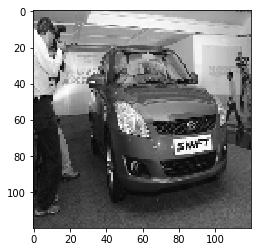

[1. 0.]


In [4]:
#%matplotlib notebook
import matplotlib.pyplot as plt
num = np.random.randint(1291)
print(num)
plt.imshow(training_data[num][0], cmap = "gray")
plt.show()
print(training_data[num][1]) 

# 2. Building the Model/Passing data in feed forward (Using PyTorch)

The architecture of the network is printed along with the number of parameters.
## Model:
1. 3 Covolution layers, with maxpool and Relu
2. 2 Fully Connected layers
3. Softmax Activation function

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.core.debugger import set_trace # For debugging in Python

# Selecting whether to run on GPU (if available) or CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

class Net(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        # Passing random data x 
        x = torch.randn(120,120).view(-1,1,120,120)
        self._to_linear = None
        self.convs(x)   # Partial forward pass  
        self.fc1 = nn.Linear(self._to_linear, 512) # Flattening , from calculation should be 2*2, 4
        self.dp1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 2)  
        self.dp2 = nn.Dropout(0.2)
    def convs(self, x):           # Passing data through conv, using Relu activation and maxpool layer 
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,(2,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,(2,2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,(2,2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
 # Feed forward propogation   
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        return F.softmax(x, dim=1)
net = Net().to(device)
# Network/Model Architecture 
print(net)

Running on the CPU
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=15488, out_features=512, bias=True)
  (dp1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dp2): Dropout(p=0.2, inplace=False)
)


# 3. Training - Loss and Optimizing parameters
1. Passing the Training data through the Model and calculating loss<b> (Mean Squared Error)</b>. Then using<b> Adam optimizer</b> to adjust parameters/weights of the model.<br>
2. <b>Default learning rate = .001 </b><br>
3. Split into test and train sets 90:10. <b> 1835 images in train, 203 in test </b>. Already shuffled.
4. Trained with<b> batch size 50 (limited by GPU) for 20 EPOCHS</b>.
5. Loss output at each Epoch below.

In [6]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = .001)  #Passing model to optimizer and setting Learning rate
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 120, 120)
X = X/255.0    # Pixel values are between 0 and 255, to transform to 0 - 1 range
y = torch.Tensor([i[1] for i in training_data])

# Creating validation set/ Test set
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT) # coverting to int as it will be used as a number to slice with
print(val_size)

203


In [7]:
train_X = X[:-val_size]
train_y = y[:-val_size]
test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

1835
203


In [16]:
BATCH_SIZE = 50 # First thing to reduce if you run into memory errors. If lower than 8, tweak the model
EPOCHS = 2

def train (net) :
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)) :  
            # Splitting in Batches
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,120,120)
            batch_y = train_y[i:i+BATCH_SIZE]
            # Data is a batch of featuremaps and labels
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) # Sending train,test batch to device (GPU if available)
            net.zero_grad()                          # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
            outputs = net(batch_X)                   # Passing batch through the network
            loss = loss_function(outputs, batch_y)   # Calculate the loss on output of network and labels Y, using MSE
            loss.backward()                          # Backward propagation of loss/Reducing loss through partial derivatives
            optimizer.step()                         # Adjusts the weight

        print(f"Epoch: {epoch}. Loss: {loss}")

train(net)    


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.2507689893245697


 35%|███▌      | 13/37 [00:27<00:52,  2.18s/it]

KeyboardInterrupt: 

# 4. Accuracy - Validating/Testing Model on validation set 

1. <b>Accuracy on test set around 85%. </b>
2. Tried multiple batch sizes, image sizes and training model for more epochs, but model couldn't improve further .
3. Possible regularization problem, either use more data, use dropout etc, better models like resnet. (Not tried in interest of time)

In [13]:
# moving testing tensors to the GPU if available
test_X.to(device)
test_y.to(device)

def test(net):
    correct = 0 
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))) :
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1,1,120,120).to(device))[0]
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class :
                correct += 1
            total += 1

    accuracy = round(correct/total,3)
    print("Accuracy :", accuracy)
    return accuracy 

accuracy =  test(net)

100%|██████████| 203/203 [00:03<00:00, 64.49it/s]

Accuracy : 0.502


# 4.1 Validation Metrics (*)

1. *From another run of the model, using different parameters.
2. created using <b>convnet-Validation_metrics.ipynb notebook.</b><br>
3. <b>Overfitting can be seen to occur around the 10th EPOCH.
  * Tried multiple batch sizes, image sizes and training model for more epochs, but model couldn't improve further .
  * Possible regularization problem, would need to either use more data, use dropout etc, better models like resnet. (Not tried in interest of time)</b> 
4. True accuracy should be around high 70's or mid 80's.

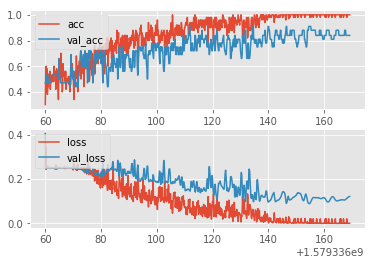

In [10]:
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = "model-1579336059" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.


def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)

# 4.2 Manual Validation

1. Manually validating examples from Test set.<br>
Output tensor index 0 - Maruti Swift <br>
Output tensor index 1 - Toyota Innova
2. Run again for random sample.

73


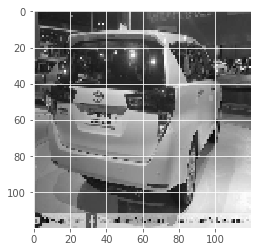

tensor(1)


In [12]:
## import matplotlib.pyplot as plt
#plt.imshow(X[2].view(50,50))
#%matplotlib notebook

num = np.random.randint(203)
print(num)
plt.imshow(test_X[num].view(120,120), cmap = "gray")
plt.show()
net_out = net(test_X[num].view(-1,1,120,120).to(device))[0]
print(torch.argmax(net_out))

# 4.3 Print Model Parameters and Save Checkpoint 
1. Printing entire models' learned parameters/weights. (commented out)
2. Saved model in the format <b> "checkpoint_acc_img_size_batch_epochs.pt"</b>.
3. Can be used for inferencing directly (section 5.)

In [16]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

print('')
print('')
print('')

print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
    #print(var_name, "\t", optimizer.state_dict()[var_name])
    
#torch.save(net, 'checkpoint' + '_acc_' + str(accuracy) + '_img_size' + str(IMG_SIZE) + '_batch_' + str(BATCH_SIZE) + '_epochs_' + str(EPOCHS)+ '.pt')


Model's state_dict:
conv1.weight 	 torch.Size([32, 1, 5, 5])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 5, 5])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([128, 64, 5, 5])
conv3.bias 	 torch.Size([128])
fc1.weight 	 torch.Size([512, 15488])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([2, 512])
fc2.bias 	 torch.Size([2])



Optimizer's state_dict:


# 5. Classify your own images/ Loading just model for inferencing 
1. dependencies mentioned here.
2. Loads best model trained.
3. Can run on the GPU.
4. <b>Load images by changing path below or replacing test.jpg in validate folder.</b>
5. Classification Ouputs Label in the form of Tensor index.<br>
Tensor [Swift, Innova]

Running on the CPU


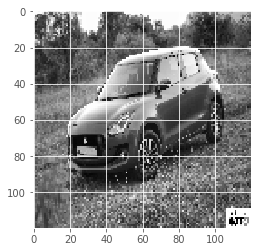

Prediction :  tensor(0)
The image is of a Maruti Swift


In [11]:
# Loading Saved model for inference 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2

# Selecting whether to run on GPU (if available) or CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")  
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
    
class Net(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        x = torch.randn(120,120).view(-1,1,120,120)
        self._to_linear = None
        self.convs(x)   # Partial forward pass
        self.fc1 = nn.Linear(self._to_linear, 512) 
        self.fc2 = nn.Linear(512, 2)  
    def convs(self, x):           
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,(2,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,(2,2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,(2,2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

net = torch.load('checkpoint_acc_0.867_img_size120_batch_50_epochs_20.pt',map_location={'cuda:0': 'cpu'})
net.eval()

img_test = cv2.imread('validate/test_2.jpg', cv2.IMREAD_GRAYSCALE)
img_test = cv2.resize(img_test, (120,120))
test_data = []
test_data.append(np.array(img_test))       
test = torch.Tensor([test_data]).view(-1, 120, 120)
plt.imshow(img_test, cmap = "gray")
plt.show()

net_out = net(test.view(-1,1,120,120).to(device))
prediction = torch.argmax(net_out)

pred_num = prediction.numpy()

if pred_num == 1 :
    print("Prediction : " , prediction)
    print("The image is of a Toyota Innova")
    
else :
    print("Prediction : " , prediction)
    print("The image is of a Maruti Swift")  